<a href="https://colab.research.google.com/github/AdamWatson91/fb_marketplace/blob/main/product_classification_mixed_modal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
!mkdir data
!cp "/content/drive/MyDrive/cleansed_product_images.npy" "data/cleansed_product_images.npy"

mkdir: cannot create directory ‘data’: File exists


In [11]:
from PIL import Image 
im=Image.open('/content/drive/MyDrive/original_256/0a1baaa8-4556-4e07-a486-599c05cce76c.jpg')

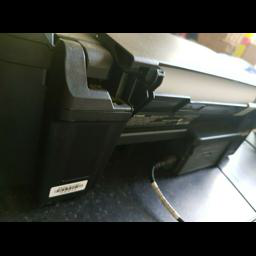

In [12]:
im

In [13]:
# Install module for Bert model
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Module imports and dataset imports

In [17]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import time
import copy
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
from google.colab import drive
from transformers import BertTokenizer
from transformers import BertModel
from tqdm import tqdm
import pickle

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')
products = np.load("data/cleansed_product_images.npy", allow_pickle=True)
products = pd.DataFrame(products, columns=['product_id', 'product_name', 'category', 'product_description', 'price', 'location', 'url', 'page_id', 'create_time', 'local_area', 'city', 'price_gbp', 'sub_cat_0', 'sub_cat_1', 'sub_cat_2', 'sub_cat_3', 'sub_cat_4', 'img_id', 'img_array'])
products

Using cuda for inference


,product_id,product_name,category,product_description,price,location,url,page_id,create_time,local_area,city,price_gbp,sub_cat_0,sub_cat_1,sub_cat_2,sub_cat_3,sub_cat_4,img_id,img_array
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,Mirror wall art,"Home & Garden / Dining, Living Room Furniture ...","Mirror wall art. Posted by Nisha in Dining, Li...",£5.00,"Wokingham, Berkshire",https://www.gumtree.com/p/mirrors-clocks-ornam...,1426704584,2022-02-26,Wokingham,Berkshire,5.0,Home & Garden,"Dining, Living Room Furniture","Mirrors, Clocks & Ornaments",<NA>,<NA>,64aa79f3-e9fa-417c-a332-714b8ce933f1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,Stainless Steel Food Steamer,Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless ste...,£20.00,"Inverness, Highland",https://www.gumtree.com/p/other-household-good...,1426704579,2022-02-26,Inverness,Highland,20.0,Home & Garden,Other Household Goods,<NA>,<NA>,<NA>,4e670f9e-7feb-458f-b529-ac52547abe2b,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,Stainless Steel Food Steamer,Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless ste...,£20.00,"Inverness, Highland",https://www.gumtree.com/p/other-household-good...,1426704579,2022-02-26,Inverness,Highland,20.0,Home & Garden,Other Household Goods,<NA>,<NA>,<NA>,a864ee52-d91e-46e7-94d1-2418e9bb2877,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,Sun loungers,Home & Garden / Garden & Patio / Outdoor Setti...,I have 2 of these - collection only as I don’t...,£20.00,"Skegness, Lincolnshire",https://www.gumtree.com/p/outdoor-settings-fur...,1426704576,2022-02-26,Skegness,Lincolnshire,20.0,Home & Garden,Garden & Patio,Outdoor Settings & Furniture,<NA>,<NA>,bfe77c38-c9eb-47fb-b3d6-31ffdefb6ff9,"[[[29, 37, 40], [22, 30, 33], [22, 30, 33], [2..."
4,59948726-29be-4b35-ade5-bb2fd7331856,Coffee side table from Ammunition ammo box hai...,"Home & Garden / Dining, Living Room Furniture ...",Great reclaimed army ammunition box used as co...,£115.00,"Radstock, Somerset",https://www.gumtree.com/p/other-dining-living-...,1426704575,2022-02-26,Radstock,Somerset,115.0,Home & Garden,"Dining, Living Room Furniture",Other,<NA>,<NA>,a92e56b7-94fc-41b4-ba6c-f2f224f42bb8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11052,2b0a652b-46a2-4297-b619-5efeeb222787,Oculus quest 2 256gb,Video Games & Consoles / Other Video Games & C...,Pick up only £250Comes with two pistols stocks...,£250.00,"Montrose, Angus",https://www.gumtree.com/p/other-video-games/oc...,1426668818,2022-02-28,Montrose,Angus,250.0,Video Games & Consoles,Other Video Games & Consoles,<NA>,<NA>,<NA>,b1466df4-594b-4f83-a66c-f9835d982c92,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
11053,719fd40a-870e-4144-b324-55dff2e66fb4,Logitech driving force shifter,Video Games & Consoles / Video Game Accessorie...,Bought at christmas from currys retailing at £...,£30.00,"Carrickfergus, County Antrim",https://www.gumtree.com/p/other-video-game-acc...,1426699715,2022-02-28,Carrickfergus,County Antrim,30.0,Video Games & Consoles,Video Game Accessories,Other Video Game Accessories,<NA>,<NA>,c8488028-bf07-4258-a4c2-56d2fe387835,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
11054,719fd40a-870e-4144-b324-55dff2e66fb4,Logitech driving force shifter,Video Games & Consoles / Video Game Accessorie...,Bought at christmas from currys retailing at £...,£30.00,"Carrickfergus, County Antrim",https://www.gumtree.com/p/other-video-game-acc...,1426699715,2022-02-28,Carrickfergus,County Antrim,30.0,Video Games & Consoles,Video Game Accessories,Other Video Game Accessories,<NA>,<NA>,dc99e40f-6b15-494d-9fb7-f0d02e9781f9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
11055,86d1806b-5575-4a7e-9160-f24f12be6c95,20 GAMES & NINTENDO SWITCH BUNDLE,Video Games & Consoles / Gam

Create text dataset made up of tokenised text and numerical labels

In [18]:
class ImageTextDataset(Dataset):
    def __init__(self, data, text_pad_length=None, transform=None):
        super().__init__()
        self.labels = data['sub_cat_0'].to_list()
        self.num_classes = len(set(self.labels))
        self.descriptions = data['product_description']
        self.descriptions_list = self.descriptions.to_list()
        if text_pad_length is None:
          avg_description_length = sum( map(len, self.descriptions_list) ) / len(self.descriptions_list)
          self.pad_length = round(avg_description_length)
        else:
          self.pad_length = text_pad_length
        self.img_array = data['img_array']
        self.files = data['img_id']
        self.category_encoder = {y: x for (x, y) in enumerate(set(self.labels))}
        self.category_decoder = {x: y for (x, y) in enumerate(set(self.labels))}
        self.tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.transform = transform
        if transform is None:
          self.transform = transforms.Compose([
                                               transforms.RandomHorizontalFlip(p=0.3),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
                                               
        assert len(self.descriptions_list) == len(self.labels)

    def __getitem__(self, index):
        label = self.category_encoder[self.labels[index]]
        label = torch.as_tensor(label)
        image = Image.open('/content/drive/MyDrive/original_256/' + self.files[index] + '.jpg')
        image = self.transform(image)
        sentence = self.descriptions.iloc[index]
        encoded = self.tokeniser.batch_encode_plus([sentence], max_length=self.pad_length, padding='max_length', truncation=True)
        encoded = {key: torch.LongTensor(value) for key, value in encoded.items()}
        with torch.no_grad():
          description = self.model(**encoded).last_hidden_state.swapaxes(1,2)

        description = description.squeeze(0).to(device)

        return (image, description, label)

    def __len__(self):
        return len(self.descriptions_list)



Can you do data augmentation with NLP?


In [42]:
class BertCNN(torch.nn.Module):
    def __init__(self, embedding_size=768, out_size=128):
        super(BertCNN, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.Conv1d(embedding_size, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, out_size)
            )

    def forward(self, X):
        X = self.layers(X)
        return X

In [43]:
class CombinedModel(nn.Module):
  def __init__(self, embedding_size=768, out_size=13):
    super(CombinedModel, self).__init__()
    resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
    out_features = resnet50.fc.out_features
    self.image_classifier = nn.Sequential(resnet50, nn.Linear(out_features, 128)).to(device)
    self.text_classifier = BertCNN()
    self.main = nn.Sequential(nn.Linear(256, out_size))

  def forward(self, image_features, text_features):
    image_features = self.image_classifier(image_features)
    text_features = self.text_classifier(text_features)
    combined_features = torch.cat((image_features, text_features), 1)
    combined_features = self.main(combined_features)
    return combined_features

In [44]:
def train_validation_test_split(data, train_percent, val_percent, batch_size, shuffle=True):
    data_size = len(data)
    train_size = int(train_percent * data_size)
    val_size = int(val_percent * data_size)
    test_size = data_size - (train_size + val_size)

    indices = list(range(data_size))
    if shuffle:
      np.random.shuffle(indices)

    train_split_indice = indices[:train_size]
    val_split_indice = indices[train_size:(val_size + train_size)]
    test_split_indice =indices[(val_size + train_size):data_size]

    # Create dictionary of dataset sizes
    dataset_sizes = {"train": train_size,
    "val": val_size,
    "test": test_size
    }

    splits = {"train": train_split_indice,
    "val": val_split_indice,
    "test": test_split_indice
    }

    samplers = {"train": SubsetRandomSampler(splits["train"]),
        "val": SubsetRandomSampler(splits["val"]),
        "test": SubsetRandomSampler(splits["test"])
        }
    
    dataset = {phase: data
        for phase in ["train", "val", "test"]}

    data_loader = {phase: DataLoader(dataset[phase], batch_size=batch_size, sampler=samplers[phase])
        for phase in ["train", "val", "test"]}

    return data_loader, dataset_sizes


In [40]:
dataset = ImageTextDataset(products, text_pad_length=292, transform=None)
batch_size = 64
data_loader, dataset_sizes = train_validation_test_split(dataset, 1, 0, 32)
print(dataset_sizes)
combined = CombinedModel()
combined.to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(combined.parameters(), lr = 0.001)
epochs = 5

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


{'train': 11057, 'val': 0, 'test': 0}


Train and save model weights for implementation into API

In [45]:
for epoch in range(epochs):
    since = time.time()
    hist_accuracy = []
    hist_loss = []
    accuracy = 0
    pbar = tqdm(enumerate(data_loader['train']), total=len(data_loader['train']))
    for i, batch in pbar:
        image_features, text_features, labels = batch
        image_features = image_features.to(device)
        text_features = text_features.to(device)
        labels = labels.to(device)
        optimiser.zero_grad()
        outputs = combined(image_features, text_features)
        loss = criterion(outputs, labels)
        loss.backward()
        accuracy = torch.mean((torch.argmax(outputs, dim=1) == labels).float().item())
        hist_accuracy.append(accuracy)
        hist_loss.append(loss.item())
        optimiser.step()
        pbar.set_description(f"Epoch = {epoch+1}/{epochs}. loss = {loss.item():.4f} Acc = {round(torch.sum(torch.argmax(outputs, dim=1) == labels).item()/len(labels), 2)}, Total_acc = {round(np.mean(hist_accuracy), 2)}" )

time_elapsed = time.time() - since
print(time_elapsed)

torch.save(combined.state_dict(), 'combined_model.pt')

with open('combined_decoder.pkl', 'wb') as f:
    pickle.dump(dataset.category_decoder, f)

  0%|          | 0/346 [00:38<?, ?it/s]


RuntimeError: ignored